In [2]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import os
from math import radians, sin, cos, sqrt, atan2

In [3]:
# List of all CSV filenames
csv_files = [
    "202109-divvy-tripdata.csv",
    "202110-divvy-tripdata.csv",
    "202111-divvy-tripdata.csv",
    "202112-divvy-tripdata.csv",
    "202201-divvy-tripdata.csv",
    "202202-divvy-tripdata.csv",
    "202203-divvy-tripdata.csv",
    "202204-divvy-tripdata.csv",
    "202205-divvy-tripdata.csv",
    "202206-divvy-tripdata.csv"
]

# Load and combine all DataFrames
dataframes = []

for csv_file in csv_files:
    if os.path.exists(csv_file):
        df = pd.read_csv(csv_file)
        dataframes.append(df)
    else:
        print(f"❌ File not found: {csv_file}")

# Combine into one final DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

# Show result
print(f"✅ Successfully loaded {len(dataframes)} files.")
print(f"🔢 Total rows combined: {combined_df.shape[0]}")
combined_df.head()

✅ Successfully loaded 10 files.
🔢 Total rows combined: 4273623


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,9DC7B962304CBFD8,electric_bike,2021-09-28 16:07:10,2021-09-28 16:09:54,NaN,NaN,NaN,NaN,41.89,-87.68,41.89,-87.67,casual
1,F930E2C6872D6B32,electric_bike,2021-09-28 14:24:51,2021-09-28 14:40:05,NaN,NaN,NaN,NaN,41.94,-87.64,41.98,-87.67,casual
2,6EF72137900BB910,electric_bike,2021-09-28 00:20:16,2021-09-28 00:23:57,NaN,NaN,NaN,NaN,41.81,-87.72,41.80,-87.72,casual
3,78D1DE133B3DBF55,electric_bike,2021-09-28 14:51:17,2021-09-28 15:00:06,NaN,NaN,NaN,NaN,41.80,-87.72,41.81,-87.72,casual
4,E03D4ACDCAEF6E00,electric_bike,2021-09-28 09:53:12,2021-09-28 10:03:44,NaN,NaN,NaN,NaN,41.88,-87.74,41.88,-87.71,casual


In [4]:
# STEP 2: Feature Engineering
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['ride_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60
df = df[(df['ride_duration'] > 0) & (df['ride_duration'] <= 1440)]

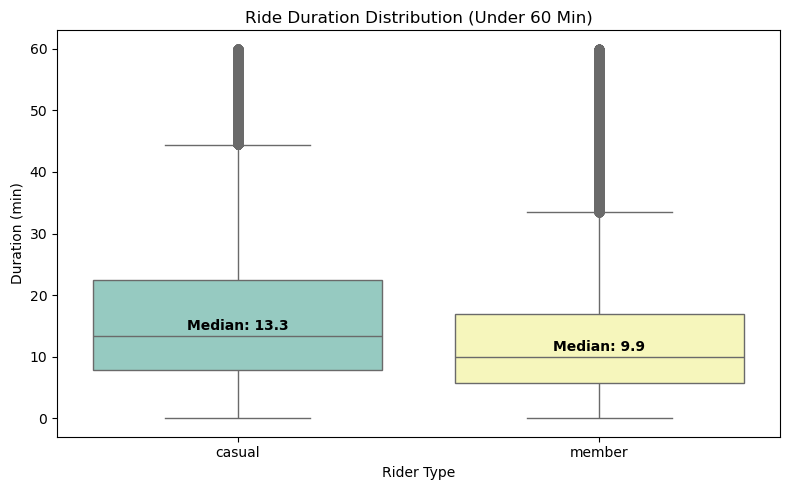

In [5]:
# --- BOX PLOT: Ride Duration by Rider Type ---
plt.figure(figsize=(8, 5))
filtered_df = df[df['ride_duration'] <= 60]

# Removed palette to avoid future warning
sns.boxplot(data=filtered_df, x='member_casual', y='ride_duration', hue='member_casual', palette='Set3')

plt.title('Ride Duration Distribution (Under 60 Min)')
plt.xlabel('Rider Type')
plt.ylabel('Duration (min)')

# Add median annotations
medians = filtered_df.groupby("member_casual")["ride_duration"].median()
for i, median in enumerate(medians):
    plt.text(i, median + 1, f"Median: {median:.1f}", ha='center', weight='bold')

plt.tight_layout()
plt.savefig("boxplot_ride_duration.png", dpi=300)
plt.show()

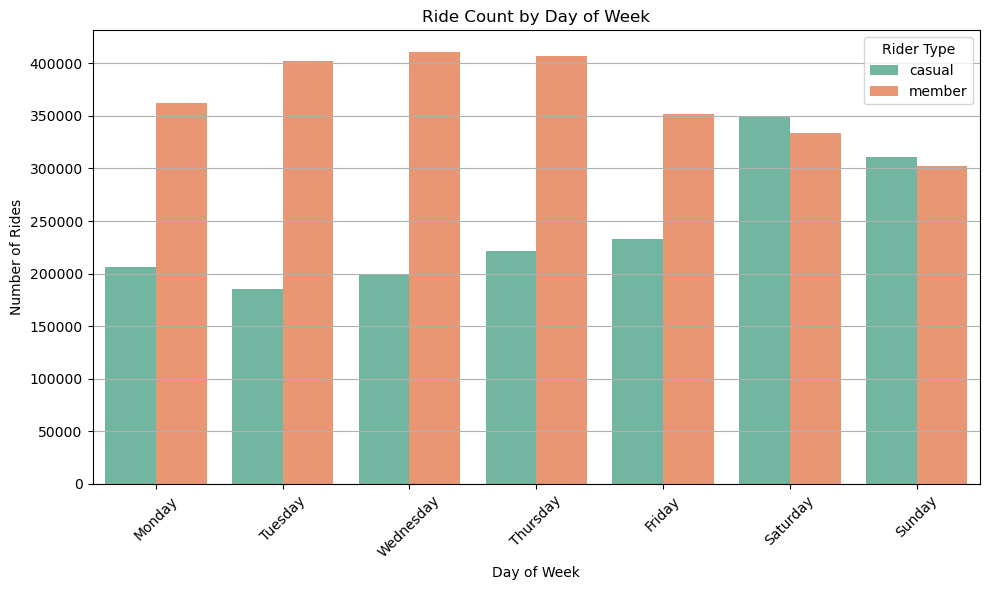

In [6]:
# Work on a full copy of the data to avoid SettingWithCopyWarning
df = combined_df.copy()

# Create day_of_week from 'started_at'
df['started_at'] = pd.to_datetime(df['started_at'])  # Ensure it's datetime
df['day_of_week'] = df['started_at'].dt.day_name()

# Define proper weekday order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)

# Group by day of week and rider type
# Group by day of week and rider type — future-proof
day_usage = df.groupby(['day_of_week', 'member_casual'], observed=True).size().reset_index(name='ride_count')

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=day_usage, x='day_of_week', y='ride_count', hue='member_casual', palette='Set2')

plt.title('Ride Count by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)
plt.legend(title='Rider Type')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


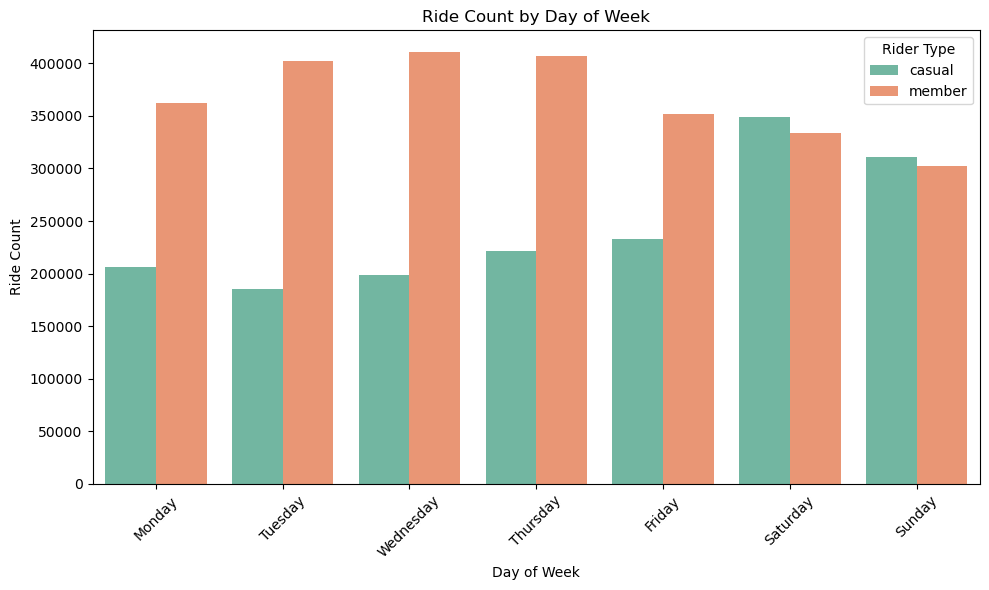

In [7]:
# Make a full copy of the original DataFrame
df = combined_df.copy()

# Ensure datetime format
df['started_at'] = pd.to_datetime(df['started_at'])

# Add day_of_week column
df.loc[:, 'day_of_week'] = df['started_at'].dt.day_name()

# Define day order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)

# Group and aggregate with future-proof setting
day_usage = df.groupby(['day_of_week', 'member_casual'], observed=True).size().reset_index(name='ride_count')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=day_usage, x='day_of_week', y='ride_count', hue='member_casual', palette='Set2')

plt.title('Ride Count by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Ride Count')
plt.xticks(rotation=45)
plt.legend(title='Rider Type')
plt.tight_layout()
plt.show()

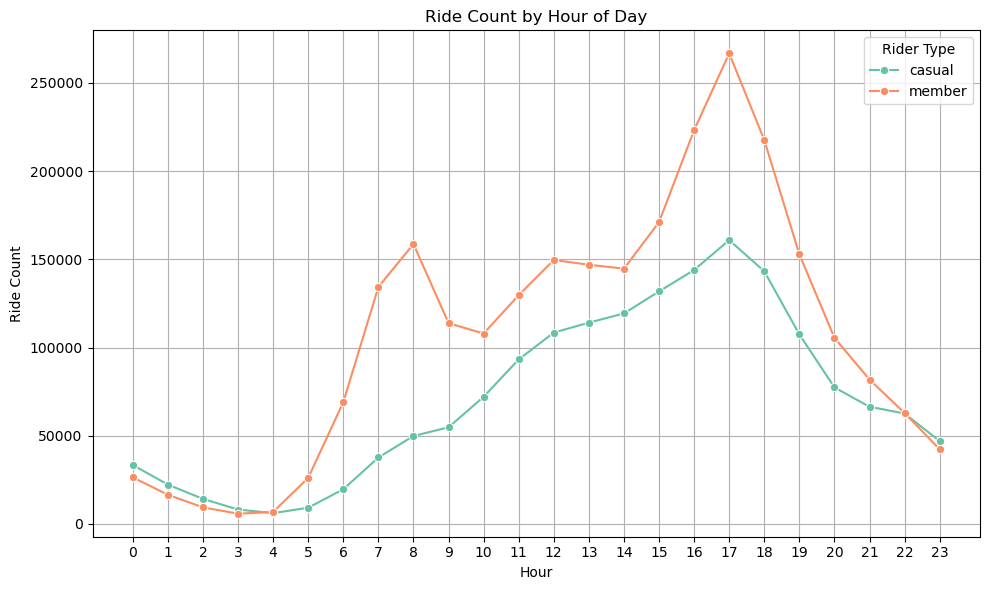

In [8]:
# --- LINE PLOT: Ride Count by Hour of Day ---
df['start_hour'] = df['started_at'].dt.hour

hourly_usage = df.groupby(['start_hour', 'member_casual']).size().reset_index(name='ride_count')

plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_usage, x='start_hour', y='ride_count', hue='member_casual', marker='o', palette='Set2')

plt.title('Ride Count by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Ride Count')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title='Rider Type')
plt.tight_layout()
plt.savefig("ride_by_hour.png", dpi=300)
plt.show()   # <- show before clearing
# plt.clf()   # optional: use only if plotting more after this

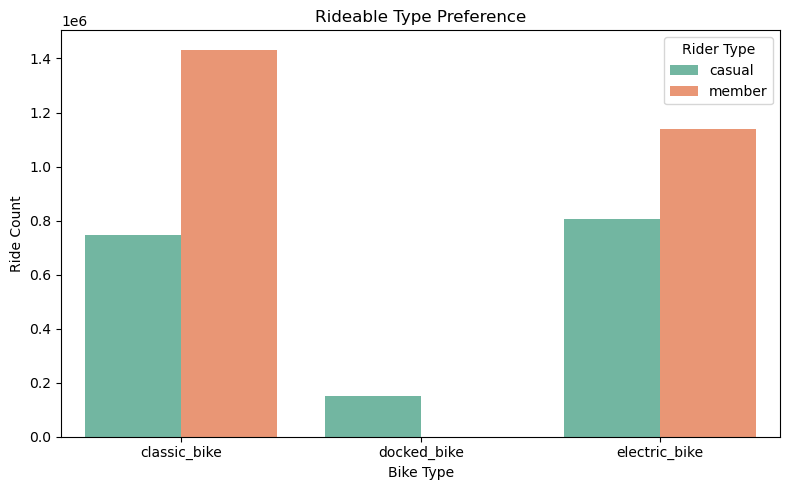

✅ Rideable Type Preference graph saved and shown.


In [9]:
# --- GROUPED BAR CHART: Rideable Type Preference by Rider ---
bike_usage = df.groupby(['member_casual', 'rideable_type']).size().reset_index(name='ride_count')

plt.figure(figsize=(8, 5))
sns.barplot(data=bike_usage, x='rideable_type', y='ride_count', hue='member_casual', palette='Set2')

plt.title('Rideable Type Preference')
plt.xlabel('Bike Type')
plt.ylabel('Ride Count')
plt.legend(title='Rider Type')
plt.tight_layout()
plt.savefig("rideable_type_preference.png", dpi=300)
plt.show()  # <-- show first
# plt.clf()  # <-- optional: only if plotting more afterwards

print("✅ Rideable Type Preference graph saved and shown.")

In [10]:
# STEP 0: Work on a copy to avoid SettingWithCopyWarning
df = combined_df.copy()

# STEP 1: Round coordinates (no warnings)
df.loc[:, 'start_lat_r'] = df['start_lat'].round(4)
df.loc[:, 'start_lng_r'] = df['start_lng'].round(4)
df.loc[:, 'end_lat_r']   = df['end_lat'].round(4)
df.loc[:, 'end_lng_r']   = df['end_lng'].round(4)

# STEP 2: Create unique coordinate-to-station mapping
all_coords = pd.concat([
    df[['start_lat_r', 'start_lng_r']].rename(columns={'start_lat_r': 'lat', 'start_lng_r': 'lng'}),
    df[['end_lat_r', 'end_lng_r']].rename(columns={'end_lat_r': 'lat', 'end_lng_r': 'lng'})
]).drop_duplicates().reset_index(drop=True)

all_coords['station_name'] = ['Station ' + str(i + 1) for i in range(len(all_coords))]

# STEP 3: Merge back to assign consistent station names
df = df.merge(all_coords, how='left', left_on=['start_lat_r', 'start_lng_r'], right_on=['lat', 'lng'])
df.rename(columns={'station_name': 'start_station_name'}, inplace=True)
df.drop(columns=['lat', 'lng'], inplace=True)

df = df.merge(all_coords, how='left', left_on=['end_lat_r', 'end_lng_r'], right_on=['lat', 'lng'])
df.rename(columns={'station_name': 'end_station_name'}, inplace=True)
df.drop(columns=['lat', 'lng'], inplace=True)
# ✅ Preview the updated DataFrame
df[['start_lat', 'start_lng', 'start_station_name', 'end_lat', 'end_lng', 'end_station_name']].head()

,start_lat,start_lng,start_station_name,start_station_name,end_lat,end_lng,end_station_name,end_station_name
0,41.89,-87.68,NaN,Station 1,41.89,-87.67,NaN,Station 242
1,41.94,-87.64,NaN,Station 2,41.98,-87.67,NaN,Station 22
2,41.81,-87.72,NaN,Station 3,41.80,-87.72,NaN,Station 4
3,41.80,-87.72,NaN,Station 4,41.81,-87.72,NaN,Station 3
4,41.88,-87.74,NaN,Station 5,41.88,-87.71,NaN,Station 292


In [11]:
print("Number of unique start stations:", df['start_station_name'].nunique())

Number of unique start stations: start_station_name     1285
start_station_name    27793
dtype: int64


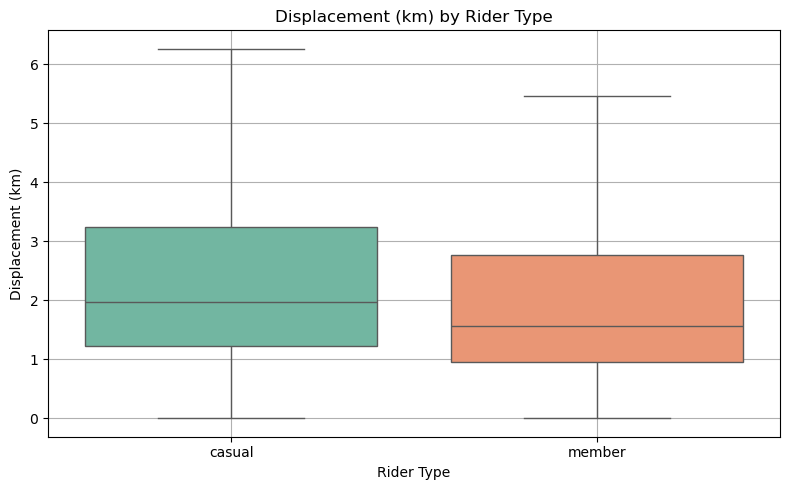

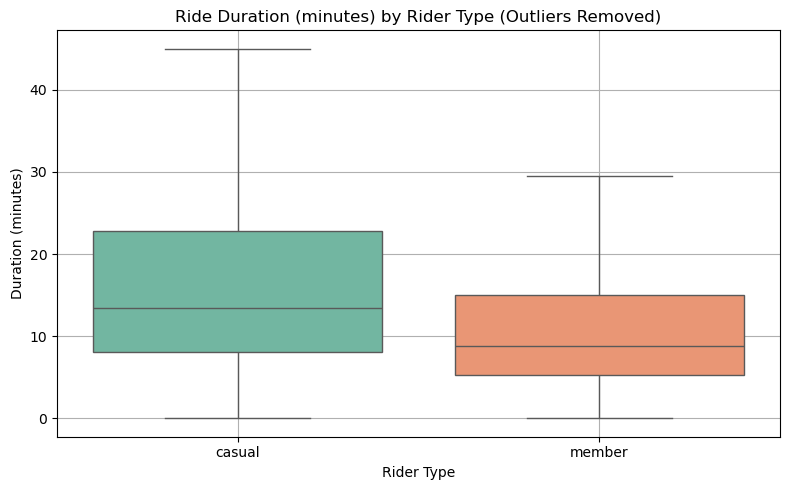

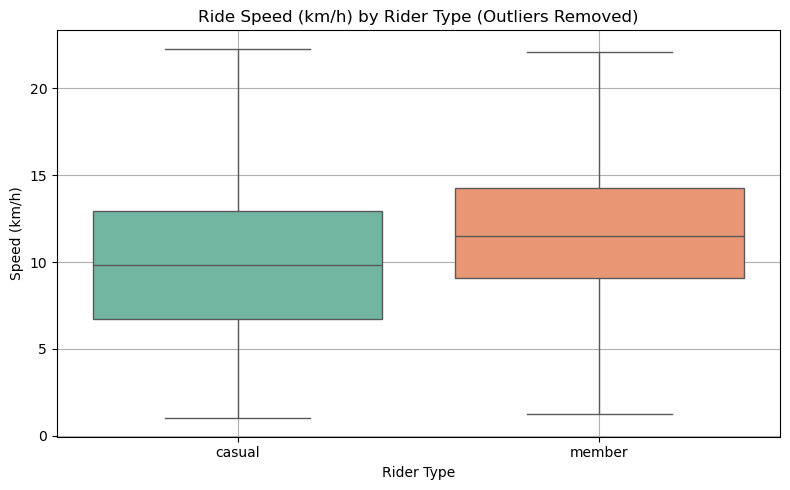

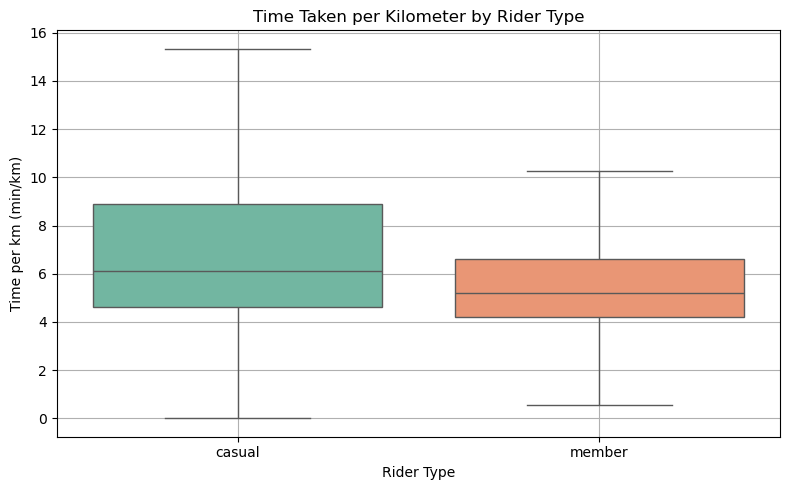

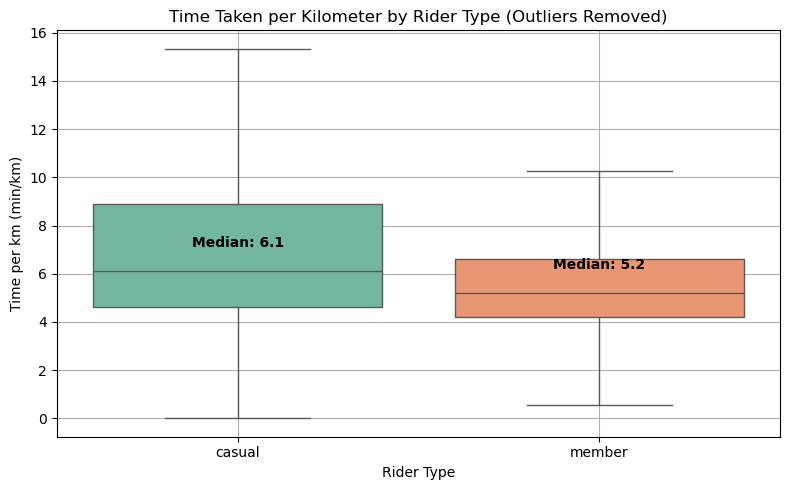

In [41]:
# --- STEP 1: Copy and datetime conversion ---
df = combined_df.copy()  # assuming combined_df already contains your 10 months of merged data
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

# --- STEP 2: Haversine function ---
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# --- STEP 3: Calculate Displacement, Duration, Speed ---
df['displacement_km'] = df.apply(lambda row: haversine(row['start_lat'], row['start_lng'],
                                                       row['end_lat'], row['end_lng']), axis=1)

df['duration_min'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60
df['speed_kmph'] = df['displacement_km'] / (df['duration_min'] / 60)
df['time_per_km'] = df['duration_min'] / df['displacement_km']

# --- STEP 4: Filter for analysis ---
df_filtered = df[
    (df['duration_min'] > 0) &
    (df['duration_min'] <= 1440) &
    (df['displacement_km'] > 0) &
    (df['time_per_km'] < 60)
]

# --- PLOT 1: Displacement ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_filtered, x='member_casual', y='displacement_km', hue='member_casual', palette='Set2', legend=False, showfliers=False)
plt.title('Displacement (km) by Rider Type')
plt.xlabel('Rider Type')
plt.ylabel('Displacement (km)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PLOT 2: Duration (no outliers) ---
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_filtered,
    x='member_casual',
    y='duration_min',
    hue='member_casual',         # Add hue to match palette use
    palette='Set2',
    showfliers=False,
    legend=False                 # Remove duplicate legend
)
plt.title('Ride Duration (minutes) by Rider Type (Outliers Removed)')
plt.xlabel('Rider Type')
plt.ylabel('Duration (minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PLOT 3: Speed (km/h) without outliers ---
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_filtered,
    x='member_casual',
    y='speed_kmph',
    hue='member_casual',
    palette='Set2',
    showfliers=False,        # ✅ Remove outliers
    legend=False
)
plt.title('Ride Speed (km/h) by Rider Type (Outliers Removed)')
plt.xlabel('Rider Type')
plt.ylabel('Speed (km/h)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PLOT 4: Time per km ---
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_filtered,
    x='member_casual',
    y='time_per_km',
    hue='member_casual',      # Fix for future Seaborn versions
    palette='Set2',
    legend=False, showfliers=False           # Prevents extra legend
)
plt.title('Time Taken per Kilometer by Rider Type')
plt.xlabel('Rider Type')
plt.ylabel('Time per km (min/km)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PLOT 5: Time per km (no outliers) with median annotations ---
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_filtered,
    x='member_casual',
    y='time_per_km',
    hue='member_casual',      # Fixes the FutureWarning
    palette='Set2',
    showfliers=False,
    legend=False
)
medians = df_filtered.groupby("member_casual")["time_per_km"].median()
for i, median in enumerate(medians):
    plt.text(i, median + 1, f"Median: {median:.1f}", ha='center', weight='bold')

plt.title('Time Taken per Kilometer by Rider Type (Outliers Removed)')
plt.xlabel('Rider Type')
plt.ylabel('Time per km (min/km)')
plt.grid(True)
plt.tight_layout()
plt.show()